In [1]:
import tensorflow as tf
from keras import Model, regularizers, activations, initializers
from keras.layers import Input, Dense, LSTM, Add, RNN, SimpleRNN
from keras.optimizers import Adam
from keras import backend as K
from keras.constraints import Constraint

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Toy dataset
ll = np.linspace(-1,1,60)
xx,yy = np.meshgrid(ll,ll)

zz = -np.cos(4 * (xx**2 + yy**2))
# zz = np.fmax(np.fmin(xx**2 + yy**2, (2*xx-1)**2  + (2*yy-1)**2 - 2), -(2*xx+1)**2  - (2*yy+1)**2 + 4)
# zz = xx**2 * (4 - 2.1 * xx**2 + xx**4 / 3) - 4 * yy**2 * (1 - yy**2) + xx * yy

inps = np.stack([xx.reshape(-1,1), yy.reshape(-1,1)], axis=-1)
inps = inps.repeat(5, axis=1)
inps_ = np.concatenate([inps,-inps], axis=-1)
targs = zz.reshape(-1,1,1)

train_inps,test_inps,train_targs,test_targs = train_test_split(inps_, targs, test_size=0.3)

In [8]:
# ICLSTM
class MinMaxConstraint(Constraint):
    """constrain model weights between [x_min, x_max]."""
    def __init__(self, x_min=0.0, x_max=1.0):
        super().__init__()
        self.x_min = x_min
        self.x_max = x_max

    def __call__(self, w):
        w_min = tf.minimum(tf.math.reduce_min(w), self.x_min)
        w_max = tf.maximum(tf.math.reduce_max(w), self.x_max)
        scale = (self.x_max - self.x_min) / (w_max - w_min)
        m = self.x_min - w_min * scale
        w = w * scale
        return w + m

    def get_config(self):
        return {'x_min': self.x_min, 'x_max': self.x_max}

class MyICLSTMCell(tf.keras.layers.Layer):

    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = [self.units, self.units]
        super(MyICLSTMCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.Wi = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer=initializers.RandomNormal(mean=0.0, stddev=0.01),
                                      name='Wi',
                                      constraint=tf.keras.constraints.NonNeg(),
                                      trainable=True)
        self.Ui = self.add_weight(shape=(self.units, self.units),
                                      initializer=initializers.Orthogonal(0.1),
                                      name='Ui',
                                      constraint=tf.keras.constraints.NonNeg(),
                                      trainable=True)
        self.DWi = self.add_weight(shape=(self.units,),
                                      initializer=initializers.RandomUniform(minval=0, maxval=1),
                                      name='DWi',
                                      constraint=tf.keras.constraints.NonNeg(),
                                      trainable=True)
        self.bi = self.add_weight(shape=(self.units,), initializer='zeros', name='bi', trainable=True)

        self.DWf = self.add_weight(shape=(self.units,),
                                      initializer=initializers.RandomUniform(minval=0, maxval=1),
                                      name='DWf',
                                      constraint=tf.keras.constraints.NonNeg(),
                                      trainable=True)
        self.bf = self.add_weight(shape=(self.units,), initializer='zeros', name='bf', trainable=True)

        self.DWo = self.add_weight(shape=(self.units,),
                                      initializer=initializers.RandomUniform(minval=0, maxval=1),
                                      name='DWo',
                                      constraint=tf.keras.constraints.NonNeg(),
                                      trainable=True)
        self.bo = self.add_weight(shape=(self.units,), initializer='zeros', name='bo', trainable=True)

        self.DWc = self.add_weight(shape=(self.units,),
                                      initializer=initializers.RandomUniform(minval=0, maxval=1),
                                      name='DWc',
                                      constraint=tf.keras.constraints.NonNeg(),
                                      trainable=True)
        self.bc = self.add_weight(shape=(self.units,), initializer='zeros', name='bc', trainable=True)

        self.built = True

    def call(self, inputs, states):
        h_tm1 = states[0]  # previous hidden state
        c_tm1 = states[1]  # previous cell state

        # scaling version
        i = tf.nn.relu(self.DWi * K.dot(inputs, self.Wi) + self.DWi * K.dot(h_tm1, self.Ui) + self.bi)
        f = tf.nn.relu(self.DWf * K.dot(inputs, self.Wi) + self.DWf * K.dot(h_tm1, self.Ui) + self.bf)
        o = tf.nn.relu(self.DWo * K.dot(inputs, self.Wi) + self.DWo * K.dot(h_tm1, self.Ui) + self.bo)
        c = tf.nn.relu(self.DWc * K.dot(inputs, self.Wi) + self.DWc * K.dot(h_tm1, self.Ui) + self.bc)

        new_c = f * c_tm1 + i * c
        new_h = o * tf.nn.relu(new_c)

        return new_h, [new_h, new_c]

    def get_config(self):
        config = super(MyICLSTMCell, self).get_config()
        config.update({"units": self.units})
        return config

input = Input(shape=(train_inps.shape[1],train_inps.shape[2]))
x_skip = input
x = RNN(MyICLSTMCell(units=64),return_sequences=True)(input)
x = Dense(train_inps.shape[2], activation='relu', kernel_constraint=tf.keras.constraints.NonNeg())(x)
x = Add()([x, x_skip])
x = RNN(MyICLSTMCell(units=64),return_sequences=True)(x)
x = Dense(train_inps.shape[2], activation='relu', kernel_constraint=tf.keras.constraints.NonNeg())(x)
x = Add()([x, x_skip])
x = Dense(1, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())(x)
model = Model(input, x)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
log = model.fit(train_inps, train_targs, epochs=2000, batch_size=64, validation_split=0.25, verbose=2)
model.summary()

Epoch 1/2000
30/30 - 62s - loss: 0.5628 - mean_squared_error: 0.5628 - val_loss: 0.5628 - val_mean_squared_error: 0.5628 - 62s/epoch - 2s/step
Epoch 2/2000
30/30 - 0s - loss: 0.5428 - mean_squared_error: 0.5428 - val_loss: 0.5465 - val_mean_squared_error: 0.5465 - 493ms/epoch - 16ms/step
Epoch 3/2000
30/30 - 0s - loss: 0.5307 - mean_squared_error: 0.5307 - val_loss: 0.5349 - val_mean_squared_error: 0.5349 - 495ms/epoch - 16ms/step
Epoch 4/2000
30/30 - 1s - loss: 0.5215 - mean_squared_error: 0.5215 - val_loss: 0.5262 - val_mean_squared_error: 0.5262 - 534ms/epoch - 18ms/step
Epoch 5/2000
30/30 - 0s - loss: 0.5150 - mean_squared_error: 0.5150 - val_loss: 0.5190 - val_mean_squared_error: 0.5190 - 500ms/epoch - 17ms/step
Epoch 6/2000
30/30 - 0s - loss: 0.5095 - mean_squared_error: 0.5095 - val_loss: 0.5125 - val_mean_squared_error: 0.5125 - 483ms/epoch - 16ms/step
Epoch 7/2000
30/30 - 0s - loss: 0.5045 - mean_squared_error: 0.5045 - val_loss: 0.5064 - val_mean_squared_error: 0.5064 - 480ms

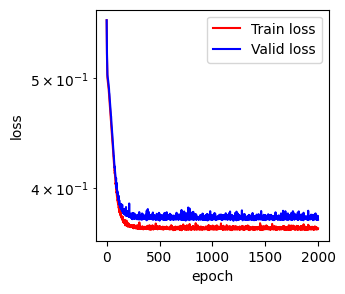

In [9]:
fig,ax = plt.subplots(figsize=(3,3))
ax.plot(log.history['loss'], 'r', label='Train loss')
ax.plot(log.history['val_loss'], 'b', label='Valid loss')
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_yscale('log')
ax.legend()

113/113 [==============================] - 1s 7ms/step


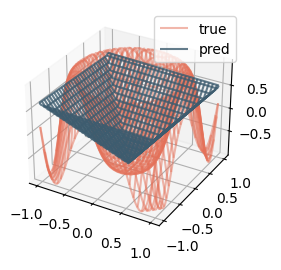

In [12]:
# time step 1
preds = model.predict(tf.convert_to_tensor(inps_, np.float32))[:,0,0].reshape((60,60))

# Plot 3D
plt.close(fig='all')
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(xx, yy, zz,    color='#E47159', alpha=0.5, label='true')
ax.plot_wireframe(xx, yy, preds, color='#3D5C6F', alpha=0.8, label='pred')
ax.legend()

113/113 [==============================] - 2s 19ms/step


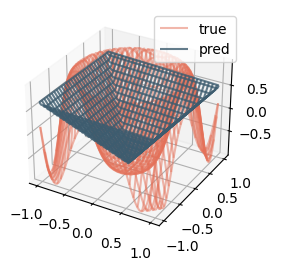

In [13]:
# time step 2
preds = model.predict(tf.convert_to_tensor(inps_, np.float32))[:,1,0].reshape((60,60))

# Plot 3D
plt.close(fig='all')
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(xx, yy, zz,    color='#E47159', alpha=0.5, label='true')
ax.plot_wireframe(xx, yy, preds, color='#3D5C6F', alpha=0.8, label='pred')
ax.legend()

113/113 [==============================] - 1s 9ms/step


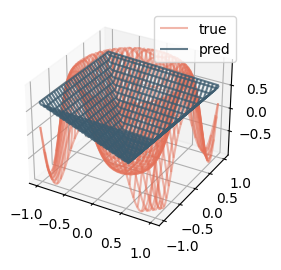

In [14]:
# time step 3
preds = model.predict(tf.convert_to_tensor(inps_, np.float32))[:,2,0].reshape((60,60))

# Plot 3D
plt.close(fig='all')
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(xx, yy, zz,    color='#E47159', alpha=0.5, label='true')
ax.plot_wireframe(xx, yy, preds, color='#3D5C6F', alpha=0.8, label='pred')
ax.legend()

113/113 [==============================] - 1s 8ms/step


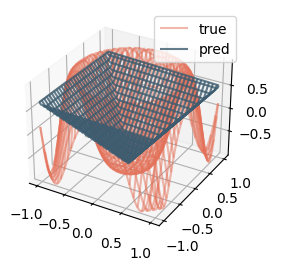

In [15]:
# time step 4
preds = model.predict(tf.convert_to_tensor(inps_, np.float32))[:,3,0].reshape((60,60))

# Plot 3D
plt.close(fig='all')
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(xx, yy, zz,    color='#E47159', alpha=0.5, label='true')
ax.plot_wireframe(xx, yy, preds, color='#3D5C6F', alpha=0.8, label='pred')
ax.legend()

113/113 [==============================] - 0s 3ms/step


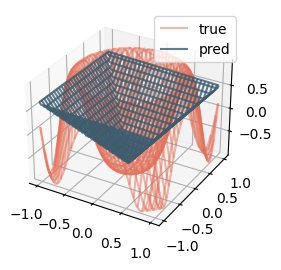

In [16]:
# last time step
preds = model.predict(tf.convert_to_tensor(inps_, np.float32))[:,-1,0].reshape((60,60))

# Plot 3D
plt.close(fig='all')
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(xx, yy, zz,    color='#E47159', alpha=0.5, label='true')
ax.plot_wireframe(xx, yy, preds, color='#3D5C6F', alpha=0.8, label='pred')
ax.legend()

fig.savefig("iclstm_cosine.pdf")

In [18]:
# ICRNN
class MyRNNCell(tf.keras.layers.Layer):

    def __init__(self, units, input_shape_custom, **kwargs):
        self.units = units
        self.input_shape_custom = input_shape_custom
        self.state_size = [tf.TensorShape([units]), tf.TensorShape([input_shape_custom])]
        super(MyRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer=initializers.RandomNormal(mean=0.0, stddev=0.01),
                                      name='kernel',
                                      constraint=tf.keras.constraints.NonNeg(),
                                      trainable=True)
        self.recurrent_kernel = self.add_weight(shape=(self.units, self.units),
                                                initializer=initializers.Orthogonal(0.1),
                                                name='recurrent_kernel',
                                                constraint=tf.keras.constraints.NonNeg(),
                                                trainable=True)
        self.D1 = self.add_weight(shape=(self.units, self.units),
                                 initializer=initializers.Orthogonal(0.1),
                                 name='D1',
                                 constraint=tf.keras.constraints.NonNeg(),
                                 trainable=True)
        self.D2 = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer=initializers.RandomNormal(mean=0.0, stddev=0.01),
                                 name='D2',
                                 constraint=tf.keras.constraints.NonNeg(),
                                 trainable=True)
        self.D3 = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer=initializers.RandomNormal(mean=0.0, stddev=0.01),
                                 name='D3',
                                 constraint=tf.keras.constraints.NonNeg(),
                                 trainable=True)
        self.V = self.add_weight(shape=(self.units, self.units),
                                 initializer=initializers.Orthogonal(0.1),
                                 name='V',
                                 constraint=tf.keras.constraints.NonNeg(),
                                 trainable=True)
        self.built = True

    def call(self, inputs, states):
        prev_h, prev_input = states
        h = K.dot(inputs, self.kernel) + K.dot(prev_h, self.recurrent_kernel) + K.dot(prev_input, self.D2)
        h = tf.nn.relu(h)
        y = K.dot(h, self.V) + K.dot(prev_h, self.D1) + K.dot(inputs, self.D3)
        y = tf.nn.relu(y)
        return y, [h, inputs]

    def get_config(self):
        config = super(MyRNNCell, self).get_config()
        config.update({"units": self.units, "input_shape_custom": self.input_shape_custom})
        return config

input = Input(shape=(train_inps.shape[1],train_inps.shape[2]))
x_skip = input
x = RNN(MyRNNCell(units=64, input_shape_custom=train_inps.shape[2]),return_sequences=True)(input)
x = RNN(MyRNNCell(units=64, input_shape_custom=64),return_sequences=True)(x)
x = Dense(1, activation='linear', kernel_constraint=tf.keras.constraints.NonNeg())(x)
model = Model(input, x)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.MeanSquaredError()])
log = model.fit(train_inps, train_targs, epochs=2000, batch_size=64, validation_split=0.25, verbose=2)
model.summary()

Epoch 1/2000
30/30 - 4s - loss: 0.4892 - mean_squared_error: 0.4892 - val_loss: 0.4798 - val_mean_squared_error: 0.4798 - 4s/epoch - 147ms/step
Epoch 2/2000
30/30 - 0s - loss: 0.4756 - mean_squared_error: 0.4756 - val_loss: 0.4692 - val_mean_squared_error: 0.4692 - 281ms/epoch - 9ms/step
Epoch 3/2000
30/30 - 0s - loss: 0.4690 - mean_squared_error: 0.4690 - val_loss: 0.4709 - val_mean_squared_error: 0.4709 - 284ms/epoch - 9ms/step
Epoch 4/2000
30/30 - 0s - loss: 0.4655 - mean_squared_error: 0.4655 - val_loss: 0.4646 - val_mean_squared_error: 0.4646 - 297ms/epoch - 10ms/step
Epoch 5/2000
30/30 - 0s - loss: 0.4581 - mean_squared_error: 0.4581 - val_loss: 0.4528 - val_mean_squared_error: 0.4528 - 447ms/epoch - 15ms/step
Epoch 6/2000
30/30 - 1s - loss: 0.4569 - mean_squared_error: 0.4569 - val_loss: 0.4533 - val_mean_squared_error: 0.4533 - 540ms/epoch - 18ms/step
Epoch 7/2000
30/30 - 1s - loss: 0.4497 - mean_squared_error: 0.4497 - val_loss: 0.4467 - val_mean_squared_error: 0.4467 - 544ms/

[]

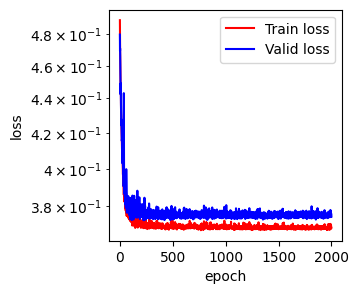

In [19]:
fig,ax = plt.subplots(figsize=(3,3))
ax.plot(log.history['loss'], 'r', label='Train loss')
ax.plot(log.history['val_loss'], 'b', label='Valid loss')
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_yscale('log')
ax.legend()
ax.plot()

113/113 [==============================] - 2s 10ms/step


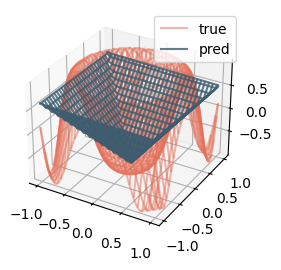

In [20]:
# time step 1
preds = model.predict(tf.convert_to_tensor(inps_, np.float32))[:,0,0].reshape((60,60))

# Plot 3D
plt.close(fig='all')
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(xx, yy, zz,    color='#E47159', alpha=0.5, label='true')
ax.plot_wireframe(xx, yy, preds, color='#3D5C6F', alpha=0.8, label='pred')
ax.legend()

113/113 [==============================] - 1s 5ms/step


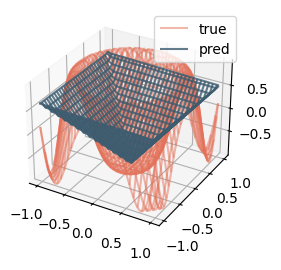

In [21]:
# time step 2
preds = model.predict(tf.convert_to_tensor(inps_, np.float32))[:,1,0].reshape((60,60))

# Plot 3D
plt.close(fig='all')
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(xx, yy, zz,    color='#E47159', alpha=0.5, label='true')
ax.plot_wireframe(xx, yy, preds, color='#3D5C6F', alpha=0.8, label='pred')
ax.legend()

113/113 [==============================] - 1s 5ms/step


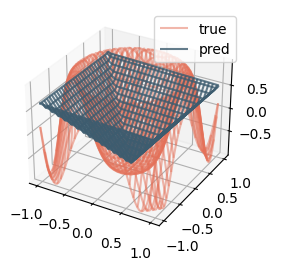

In [22]:
# time step 3
preds = model.predict(tf.convert_to_tensor(inps_, np.float32))[:,2,0].reshape((60,60))

# Plot 3D
plt.close(fig='all')
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(xx, yy, zz,    color='#E47159', alpha=0.5, label='true')
ax.plot_wireframe(xx, yy, preds, color='#3D5C6F', alpha=0.8, label='pred')
ax.legend()

113/113 [==============================] - 1s 5ms/step


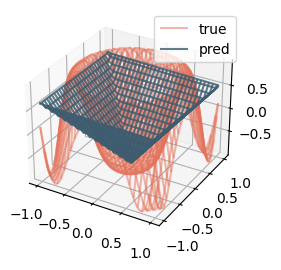

In [23]:
# time step 4
preds = model.predict(tf.convert_to_tensor(inps_, np.float32))[:,3,0].reshape((60,60))

# Plot 3D
plt.close(fig='all')
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(xx, yy, zz,    color='#E47159', alpha=0.5, label='true')
ax.plot_wireframe(xx, yy, preds, color='#3D5C6F', alpha=0.8, label='pred')
ax.legend()

113/113 [==============================] - 0s 3ms/step


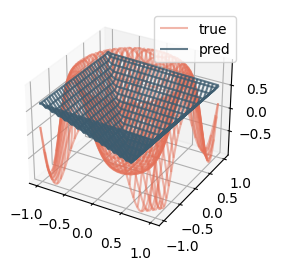

In [24]:
# last time step
preds = model.predict(tf.convert_to_tensor(inps_, np.float32))[:,-1,0].reshape((60,60))

# Plot 3D
plt.close(fig='all')
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(xx, yy, zz,    color='#E47159', alpha=0.5, label='true')
ax.plot_wireframe(xx, yy, preds, color='#3D5C6F', alpha=0.8, label='pred')
ax.legend()

fig.savefig("icrnn_cosine.pdf")